## SIFT and RANSAC
### Florian Heringa
### 10385835
### UvA -- Computer Vision and Image Processing

In [101]:
# Import statements

import cv2
import numpy as np
import matplotlib.pyplot as plt

from pylab import rcParams
from skimage.transform import warp
from numpy.random import randint
from sklearn.model_selection import train_test_split

#ipython setting
rcParams['figure.figsize'] = (20, 12)

$\newcommand{\vecl}[1]{\begin{pmatrix}#1\end{pmatrix}}$ 
$\newcommand{\hvec}[1]{\widetilde{\boldsymbol{#1}}}$
$\newcommand{\nvec}[1]{\boldsymbol{#1}}$

## Introduction

In this report SIFT is used to stitch two images together. First two images of the nachtwacht are being stitched using openCV code  after which the SIFT algorithm will be explained. Finally, the RANSAC algorithm is explained and used to stich the images together.

Below a function is defined for use in finding a projective transform in the way detailed in the week 2 report. The only difference is that this function takes an arbitrary number of points and from that estimates the projective matrix.

In [56]:
def perspectiveTransform(p1, p2):
    
    M = np.array([[p1[int(n/2)][0], p1[int(n/2)][1], 1, 0, 0, 0, -p1[int(n/2)][0] * p2[int(n/2)][0], -p2[int(n/2)][0] * p1[int(n/2)][1], -p2[int(n/2)][0]] if n % 2 == 0 else
                  [0, 0, 0, p1[int(n/2)][0], p1[int(n/2)][1], 1, -p1[int(n/2)][0] * p2[int(n/2)][1], -p2[int(n/2)][1] * p1[int(n/2)][1], -p2[int(n/2)][1]] for n in range(2 * len(p1))])

    U, D, V_t = np.linalg.svd(M)
    # Taking the last row of V_t (same as last column of V) and reshape to 3x3 matrix
    return V_t[-1].reshape((3, 3))

# Helper function for finding the max and min values fo the transformation given a square image of 
# range defined by arguments
def getTransformRange(upper_left, lower_right, p):
    
    lu = np.dot(np.linalg.inv(p), np.array([upper_left[0], upper_left[1], 1]))
    ll = np.dot(np.linalg.inv(p), np.array([lower_right[0], upper_left[0], 1]))
    ru = np.dot(np.linalg.inv(p), np.array([upper_left[1], lower_right[1], 1]))
    rl = np.dot(np.linalg.inv(p), np.array([lower_right[0], lower_right[1], 1]))
    
    lu /= lu[2]
    ll /= ll[2]
    ru /= ru[2]
    rl /= rl[2]
    
    min_x = min(lu[0], ll[0], ru[0], rl[0])
    min_y = min(lu[1], ll[1], ru[1], rl[1])
    max_x = max(lu[0], ll[0], ru[0], rl[0])
    max_y = max(lu[1], ll[1], ru[1], rl[1])
    
    return min_x, max_x, min_y, max_y

perspectiveTransform([(1,1), (1, 2)], [(1, 3), (2, 6)])

array([[ 0.29111632,  0.0011691 , -0.05140594],
       [ 0.55268501,  0.00350729,  0.16644613],
       [-0.31963267, -0.11985519,  0.68036733]])

Below we first load two images which have some overlap, then 7 points are manually chosen tha correspond to the same point in the image. These images and points are plotted next to each other, then the corresponding perspective transformation is calculated from these points using the function defined above. Finally the entire right image is transformed and stitched together with the left image. Because of errors in selecting the points the stitching is not perfect and will need some adjustment. 

Also an adjustment has been made to ensure that the resulting image is fully visible in the final plot. To get to this result first the transformation matrix is analysed to get the transformation locations of the corner points of the image to transform. Then a translation matrix is calculated and applied to the perspective transform matrix so that the image will be transformed and then be translated into view in a single operation. Finally the left image needs to be translated too with the same translation as the transformed image, otherwise they will not be matching. Also the output shape of the resulting image is controlled in a similar manner. Unfortunately I have not been able to get the image to fit snugly into the frame and there seems to be a bit more error, which I assume comes from applying a translation on an estimated matrix, which amplifies the error in the total transformation.

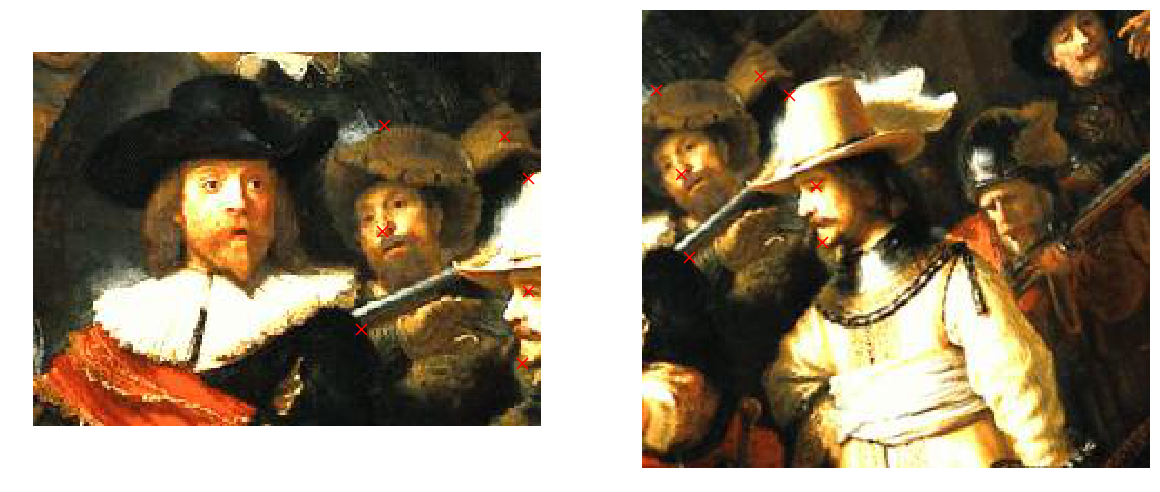

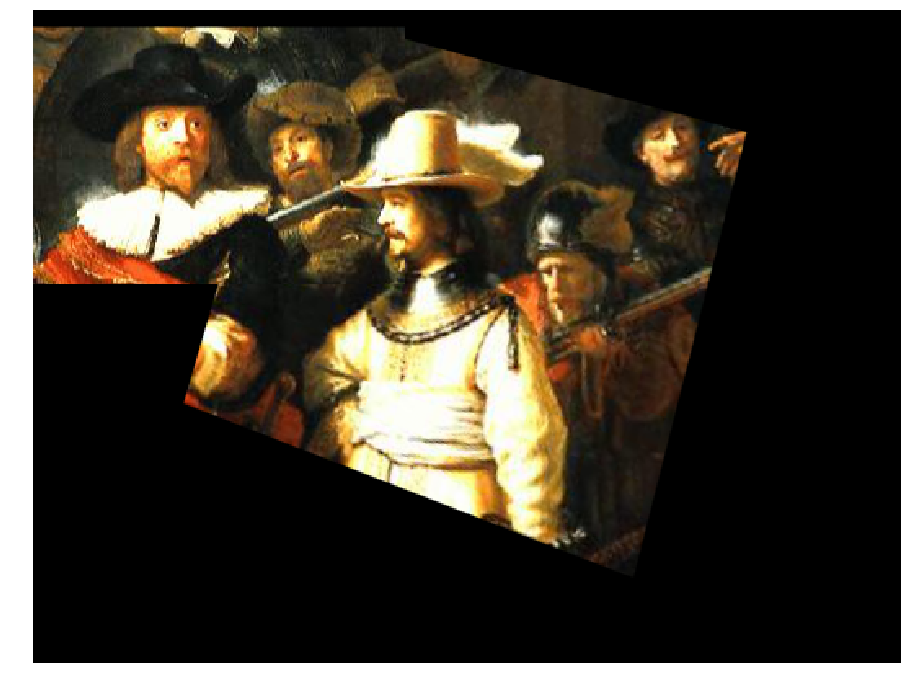

In [87]:
# Load two images
f1 = plt.imread('nachtwacht1.jpg')/255
f2 = plt.imread('nachtwacht2.jpg')/255

# Select 7 points in the left image
xy = np.array([[ 157, 32],
               [ 211, 37],
               [ 222,107],
               [ 147,124],
               [ 156, 80], 
               [ 219,139],
               [ 222, 56]])


# Select corresponding 7 points in the righ image
xaya = np.array([[  6, 38],
                 [ 56, 31],
                 [ 83, 84],
                 [ 22,118],
                 [ 18, 78],
                 [ 86,111],
                 [ 70, 40]])

# Plot images and points
plt.subplot(121); plt.imshow(f1); plt.axis('off');
plt.scatter(xy[:,0], xy[:,1], marker='x', color='red', s=120);
plt.subplot(122); plt.imshow(f2); plt.axis('off');
plt.scatter(xaya[:,0], xaya[:,1], marker='x', color='red', s=120);
plt.show()

# Calculate the transformation matrix belonging to the selected points
p = perspectiveTransform(xy.astype(np.float32), xaya.astype(np.float32))

# Get minimum and maximum values of transformed image
min_x, max_x, min_y, max_y = getTransformRange((0, 0), (256, 256), p)

# Translation matrix for fitting entire image to plot
tr_matrix = np.array([[1, 0, min_x if min_x < 0  else 0], 
                      [0, 1, min_y if min_y < 0  else 0], 
                      [0, 0,                          1]])

# Apply translation to perspective matrix
p = np.dot(p, tr_matrix)
shape_y = max_y - min_y if min(max_y, min_y) < 0 else max_y + min_y
shape_x = max_x - min_x if min(max_x, min_x) < 0 else max_x + min_x
f_stitched = warp(f2, p, output_shape=(int(shape_y), int(shape_x)))

M, N = f1.shape[:2]

f_stitched[0:M, 0:N, :] = warp(f1, tr_matrix)

plt.imshow(f_stitched)
plt.axis('off')
plt.show()

# SIFT - theory

The SIFT (Scale Invariant Feature Transform) algorithm is an algorithm invented by David Lowe. It makes use of the scale space of gaussian derivative convolutions to estimate the laplacian of the image, which, according to the article gives the most stable way of finding features in images. 

In SIFT a scale space is first created for the image where the original image is repeatedly convolved with a gaussian derivative kernel. They key to this repeated convolution that makes the scale invariance of the algorithm is the use of octaves in the creation of the scale-space. An octave is defined to be a doubling of the scale (s) of the gaussian derivative, since the gaussian smooths the image, local information gest spread out and lost with every convolution. Because of this it is allowed to subsample every time an octave has been reached. Where subsampling means lowering the size of the image by, for example, taking every 4x4 environment and replacing it by the upper left pixel. This reduces the size of the image by a factor of 4 and generally would decrease the amount of information in an image. However, with the gaussian convolution applied beforehand, the information has been lost already. This 'loss' of information is certainly not a problem, and actually makes for what is the working force behind the algorithm, because now we can go over the octaves with a constant sized feature detector, which in this case is defined as the comparison of a pixel with it's 27 neighbors (remember, we are working in a scale space, so next to the usual 8 cartesian neighbors there are also 9 below and above in the previous and next convolution in the octave) and checking if it is a local maximum or minimum. If this is true, then a possible 'keypoint' has been found, to check whether this keypoint is actually a good location for calculating a descriptor a 3D quadratic function is fitted through the points. This is done by using a Taylor expansion around the keypoint candidate by determining the derivatives in all directions simply by calculating the differences between neighbors. This fitting step makes sure that the points that are selected as keypoints have a significant contrast with respect to their neighbors, such that unclear feutures are not kept.

Since we are looking for peaks, and not edges in the local neighborhoods, another test is applied on the keypoints. Here the Hessian matrix is used to find the principal curvature in the neighborhood. By only making use of the ratio of eigenvalues of the Hessian this step can be performed quite efficiently. More information is not necessary here, as the ratio of eigenvalues contains all information. For example, when the keypoint is an actual minimum or maximum, the ratio is close to 1, as the principal curvature is approximately the same in both directions. However, a hiher deviation dennotes that the peak is ill defined and as such should be ignored.

After this last test a selection of initial keypoint candidates remain (the article sugests about 60\%) of which a descriptor will be formed. From the prvious stage the scale of the gaussian where the keypoint was found is used in computation, this ensures the scale-invariance included in the name. This scale is used to create an image with a gaussian convolution closest to where the keypoint was found, the keypoint is not necessarily exactly contained in one of the discrete samples that were taken to create the scale space, or even the pictures themself. By using the fitting step before, the keypoint has been determined wth sub-pixel accuracy and thus a new image is needed with a gaussian convolution that resembles the scale of the keypoint more accurately. Around the keypoint the gradient mgnitude and direction are weighted with a gaussian window 1.5 times the scale of the keypoint. The article gives no motivation for this, but I assume it is because this makes the keypoint contain slightly more information about the environment. Finally, these orientations are combined into a histogram (HOG - Histogram of Oriented Gradients) where the peak of the histogram shows the main direction of the descriptor. Sometimes it is opossible for the histogram to have multiple peaks, which is solved by adding multiple keypoints, which have different orientations but are the same otherwise.

Finally, to decrease the size of the feature vector, the values are summarised over 16x16 areas around the keypoint yielding a 4x4 array of HOGs with each 8 bins. This gives a final feature vector of 4 x 4 x 8 = 128 elements per keypoint.

# SIFT in action

In the following section of code the matching function of cv2 has been tested, again we load the same two images and rearrange the order of coloring in the images since openCV wants it this way. We then use SIFT to calculate the keypoints in both images and plot them in the images with green circles. From this some correspondences can already be seen. Then a cv2 matcher is created and the keypoints are used to find the matches between the images. Also, some of the matches are plotted in the image. The top image shows the best 25 matches which seem to be quite accurately matched beween images. The lower image shows the 25 worst matches, and it can clearly be seen that many of these are complete nonsense, this is also visible in the output of the code, where it can be seen that all 309 keypoints in the first image are matched to keypoints in the second image, which simply cannot be correct for images which are not exactly the same. A percentage of these matches is clearly wrong and has to be filtered out, this is where the RANSAC algorithm (described in the following section) is usefull.

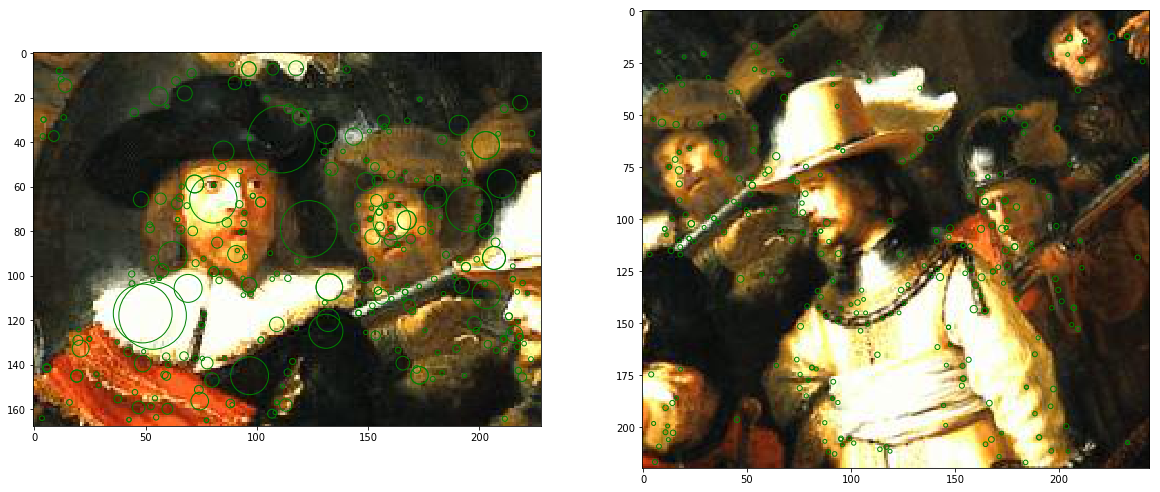

Keypoints in image 1: 309
Keypoints in image 2: 478
Total amount of matches found: 309


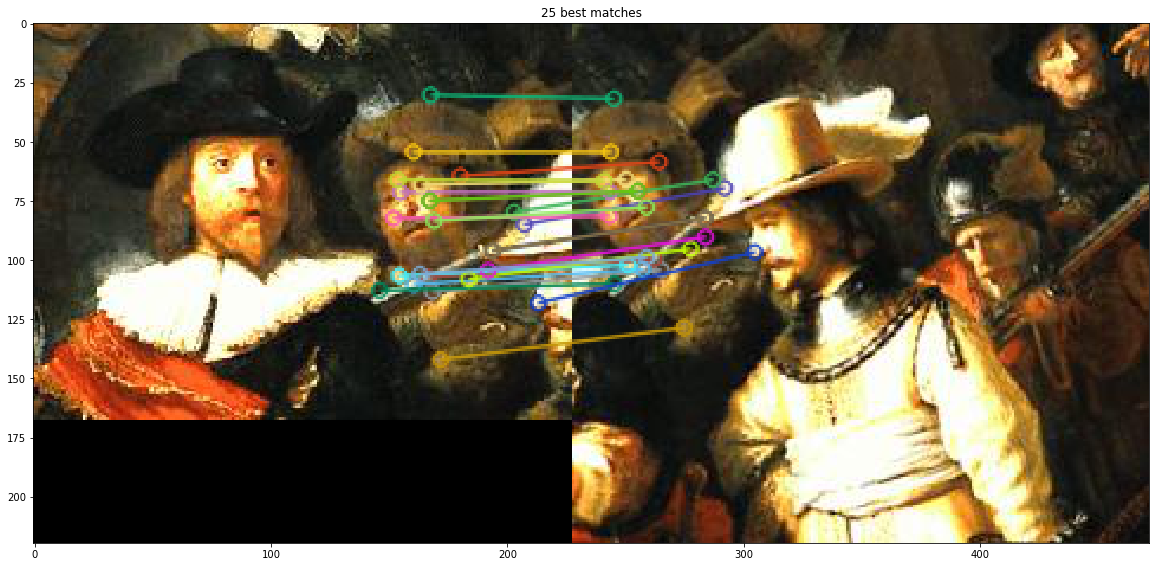

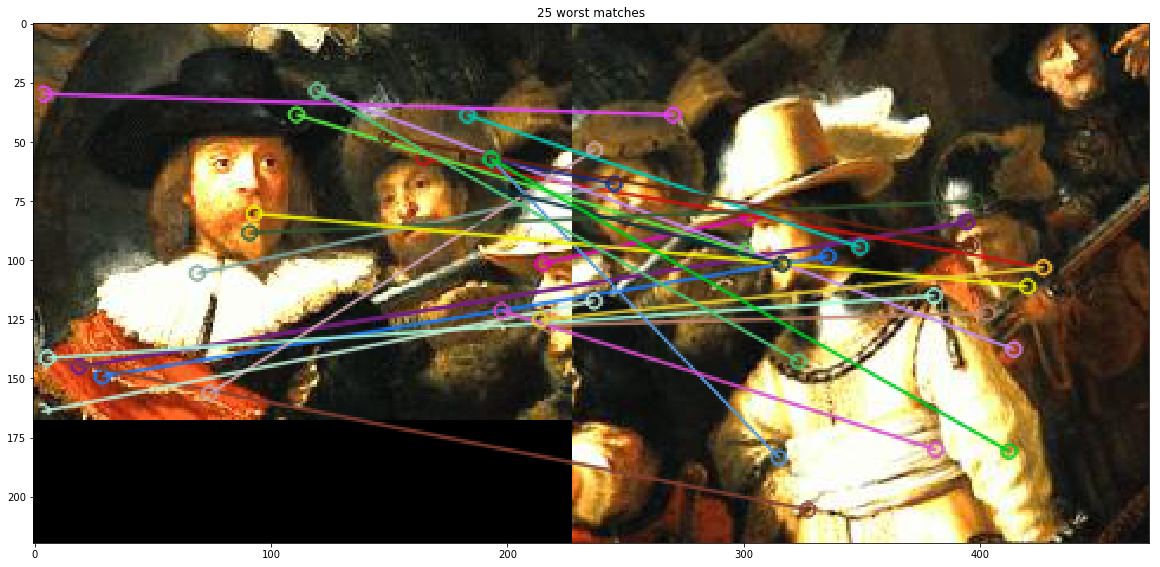

In [86]:
f1 = plt.imread('nachtwacht1.jpg')
f2 = plt.imread('nachtwacht2.jpg')

f1cv2 = f1[:,:,::-1] # OpenCV uses BGR ordering of color channels
f2cv2 = f2[:,:,::-1] # OpenCV uses BGR ordering of color channels
fig, axes = plt.subplots(1, 2)
axes[0].imshow(f1)
axes[1].imshow(f2)
sift = cv2.xfeatures2d.SIFT_create()
kps1, dscs1 = sift.detectAndCompute(f1cv2, mask=None)
kps2, dscs2 = sift.detectAndCompute(f2cv2, mask=None)

for kp1, kp2 in zip(kps1, kps2):
    axes[0].add_artist(plt.Circle((kp1.pt), kp1.size/2, color='green', fill=False))
    axes[1].add_artist(plt.Circle((kp2.pt), kp2.size/2, color='green', fill=False))

plt.show()

matcher = cv2.BFMatcher()
matches = matcher.match(dscs1,dscs2)
matches = sorted(matches, key = lambda x:x.distance)

print("Keypoints in image 1: %d" % len(kps1))
print("Keypoints in image 2: %d" % len(kps2))
print("Total amount of matches found: %d" % len(matches))

best_matches = cv2.drawMatches(f1,kps1,f2,kps2,matches[:25], None, flags=2)
plt.imshow(best_matches)
plt.title("25 best matches")
plt.show()

worst_matches = cv2.drawMatches(f1,kps1,f2,kps2,matches[-25:], None, flags=2)
plt.imshow(worst_matches)
plt.title("25 worst matches")
plt.show()

# RANSAC

The RANSAC algorithm (Random Sample Consensus) is an iterative brute force method of finding a best fit from a dataset. For example, it can be used to find a good fit for a lnie from cartesian data. The strength of RANSAC lies in the fact that it is capable of dealing with data where many outliers or noise sources are present. There are a few simple steps to the algorithm, as detailed below

1. Pick n random points from the data
2. Calculate the fit model using these points
3. Calculate the inliers of the model from the rest of the data. This means that all other points are being compared to the model and that a threshold t is applied to determine if a point is within the fit found in step 2.
4. If the number of inliers found in step 3 are more than another predetermined value d, the model seems to be a good fit for the data. Refti the model to all points from step 1 and all points in the list gotten from step 3.
5. If this model now gives a lower error than any other error found before (initialised at a very high value) we accept the model.
6. Repeat until either the result doesn't change anymore, or a predetermined amount of iterations has been achieved.

In [132]:
# Select n random points from the data, since the train_test_split function takes tes-size
# as a fraction between 0 and 1, this is first calculated.
def keypointRandomizeSelect(kps1_hc, kps2_hc, n):
    
    # Take n random items from the keypoints
    test_size = 1 - n/len(kps1_hc)
    pairs = np.hstack((kps1_hc, kps2_hc))
    test_pairs, rest_pairs = train_test_split(pairs, test_size=test_size)
    
    test_1 = test_pairs[::, :3:]
    rest_1 = rest_pairs[::, :3:]
    test_2 = test_pairs[::, 3::]
    rest_2 = rest_pairs[::, 3::]
    
    return test_1, rest_1, test_2, rest_2

# For each keypoint in the original image, it is transformed 
def getError(p, kps1_hc, kps2_hc, matches):
    
    err = 0
      
    for n in range(len(matches)):
        # Transform original image
        transf = np.dot(p, kps1_hc[n])
        # Calculate euclidean distance between calculated point and actual keypoint location
        # includes renormalisation of homogeneous coordinates
        err += np.linalg.norm((transf / transf[2]) - kps2_hc[n])
        
    return err

# Find inliers and return indices of these inliers in the list of keypoints
def getInliers(calculated, target, threshold):
    
    inliers = 0
    inliers_indices = []
    
    for n in range(len(target)):
        if np.linalg.norm(calculated[n] - target[n]) < threshold:
            inliers += 1
            inliers_indices.append(n)
            
    return inliers, inliers_indices

36717.6173797


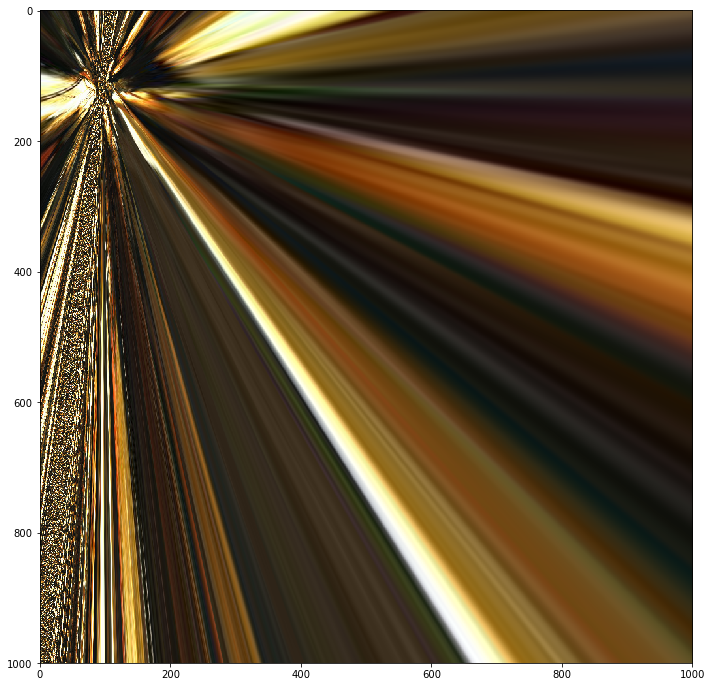

In [142]:
from skimage.transform import warp
from sys import maxsize

def RANSAC(kps1, kps2, matches, selectRandom, fitFunc, inlierFunc, errorFunc,  
           iterations=1000, points=25, threshold=10, minInliers=10):
    
    bestFit = None
    bestErr = maxsize
    kps1_hc = []
    kps2_hc = []
    
    # Extract matches from keypoints in images in order of matches as homogeneous coordinates
    for match in matches:
        kps1_hc.append(np.hstack((kps1[match.queryIdx].pt, [1])))
        kps2_hc.append(np.hstack((kps2[match.trainIdx].pt, [1])))

    for n in range(iterations):
        
        # Seperate data into train and test data
        test_1, rest_1, test_2, rest_2 = selectRandom(kps1_hc, kps2_hc, points)
        # Find best fit for selected keypoints
        p = fitFunc(test_1, test_2)

        # Apply transformation matrix on all other keypoints that were not used to calculate the matrix
        transformed = []
        for pt in rest_1:
            temp = np.dot(p, pt)
            # Renormalize homogeneous coordinates
            transformed.append(temp/temp[2])

        # Get amount of inliers in the model by calculating difference between calculated and actual keypoints
        inliers, indices = inlierFunc(transformed, rest_2, threshold)
        
        if inliers > minInliers:
            p = fitFunc(np.vstack((test_1, rest_1[indices])), np.vstack((test_2, rest_2[indices])))
            error = errorFunc(p, kps1_hc, kps2_hc, matches)
            if error < bestErr:
                bestErr = error
                bestFit = p
                
    return bestFit, bestErr

p, err = RANSAC(kps1, kps2, matches, keypointRandomizeSelect, perspectiveTransform, getInliers, getError)
    
print(err)
plt.imshow(warp(f2, np.linalg.inv(p), order=3, mode='reflect', output_shape=(1000, 1000)))
plt.show()   

Unfortunately, as can be seen above, I have not been able to implement the RANSAC algorithm to stitch images together. Why exactly this does not work I do not know. In detailing here what my thougth process is, I hope to give enough information so the problem may be identified. 
To get the RANSAC algorithm to work I first set bestFit and BestError to dummy initial vaues. Then I make empty lists for containing the location of keypoints in homogeneous coordinates. These lists are filled with the actual points with a 1 appended to them, also they are stored in a way that makes indexing easier later on, as they are sorted in matches between lists (kps1_hc[n] matches with kps2_hc[n]). This also makes it that the 'matches' array is not needed any further. After this the actual algorithm starts; the sklearn function is used to seperate the keypoints into two sets, a train and a test set. From the learn set the transform matrix is determined. For all points the transformation is aaplied on the points from the test set, after which they are renormalised to homogeneous coordinates with scale factor 1.  After this the inliers of the model are calculated with the threshold value, this is done by going over all test keypoints and comparing the transformed first points with the matching points in the second image. If the euclidean distance between the points is then lower than the threshold, the point is deemed and inlier and the index of the opint is saved. These indices and the number of inliers is then returned and compared with the minimum number of inliers needed. If the inliers in the model are more than minimally necessary we continue.

In the following step the model is fitted again for all points in the test set and all points that were found to be inliers in the previous step. This second fit is then applied to all keypoints of the first image and the error is calculated by again calculating the euclidean distance between actual keypoints and transformed keypoints. This iteration is repeated for a predetermined number of iterations after which the best perspective transform matrix should roll right out.

Unfortunately this does not seem the case and after staring at this and tweaking values for about a day I decided to give up on it. I would very much like to review the code so I can find the error I have made with one of the assistants sometime.